# Modelo de Regression

En este notebook se presentara un analisis exploratorio del flujo de pasajeros del transporte de metro de Londres con los datos procesados previamente en el ETL. A continuacion, desarollamos un modelo de regresion para predecir el volumen de pasajeros a traves de estos datos.

# Notebook Set Up

In [3]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado (por si los usas después del EDA)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

# Estadística
import scipy.stats as stats

In [5]:
import os

# muestra la ruta actual (equivalente a pwd en terminal)
os.getcwd()

'/Users/nicoletondu/Desktop/data-science-thesis-2025/ml-notebooks'

In [11]:
# show all columns when printing
pd.set_option('display.max_columns', None)

In [17]:
# Read the data with proper data types to avoid mixed type warnings
df = pd.read_csv("../data/processed/passengers_enriched_2023.csv", 
                 type={'event_type': 'object', 'event_name': 'object'})

TypeError: read_csv() got an unexpected keyword argument 'type'

In [9]:
df.head()

,date,dayofweek,station_name,station_uid,mode,line,farezones,hubnaptancode,entrytapcount,exittapcount,...,service_operated_weekday_pct,service_operated_weekend_pct,kilometres_operated,wifi,airportinterchange,bluebadgecarparking,bluebadgecarparkspaces,toilet_isaccessible,toilet_isfeecharged,toilet_type
0,2023-01-01,Sunday,Acton Central,910GACTNCTL,overground,mildmay,3,NaN,779,709,...,NaN,NaN,NaN,True,NaN,False,0.0,NaN,NaN,NaN
1,2023-01-01,Sunday,Acton Main Line,910GACTONML,elizabeth-line,elizabeth,3,NaN,1087,967,...,NaN,NaN,NaN,False,NaN,False,0.0,True,False,Unisex
2,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Male
3,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Female
4,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,True,False,Unisex


In [118]:
df_tube = df[df['mode'] == 'tube']

In [120]:
df_tube.isnull().sum().sort_values(ascending=False)


airportinterchange              182439
hubnaptancode                   181526
expected_attendance             179384
event_name                      175584
event_type                      175584
toilet_type                      85734
toilet_isfeecharged              85734
toilet_isaccessible              85734
service_operated_allweek_pct     16865
service_operated_weekday_pct     16865
service_operated_weekend_pct     16865
kilometres_operated              16865
bluebadgecarparkspaces             916
cloud_cover                          0
wifi                                 0
bluebadgecarparking                  0
sea_level_pressure                   0
sunshine_duration                    0
date                                 0
relative_humidity                    0
dayofweek                            0
mean_temp                            0
min_temp                             0
max_temp                             0
exittapcount                         0
entrytapcount            

In [122]:
df_tube.shape

(182439, 32)

almost 100% of missing fields for airportinterchange and hubnaptancoe. Dropping these columns for the initial EDA.

In [111]:
cols_drop_now = ['airportinterchange', 'hubnaptancode']  # fully/almost empty
df_eda = df.drop(columns=cols_drop_now)

### Entry Tap Count (Demand)

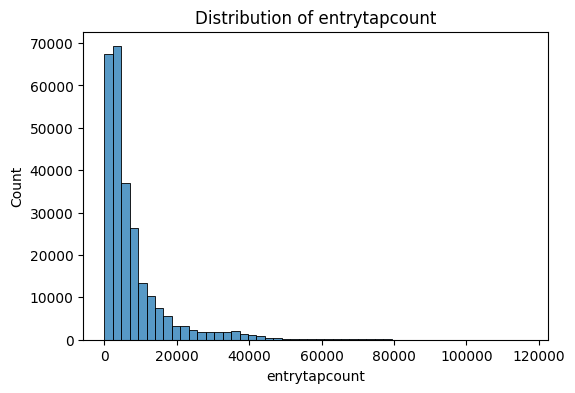

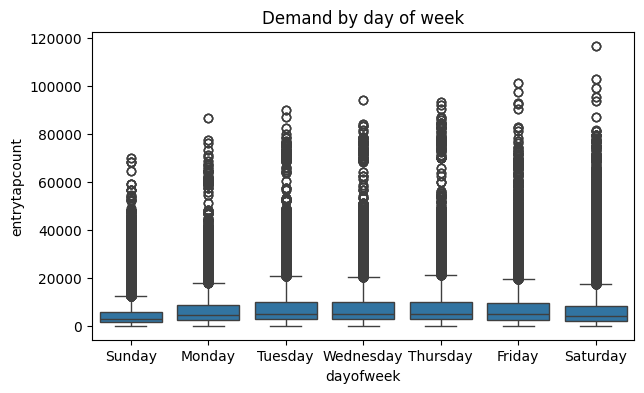

In [114]:
target = 'entrytapcount'

# distribution & outliers
plt.figure(figsize=(6,4))
sns.histplot(df_eda[target], bins=50)
plt.title('Distribution of entrytapcount'); plt.show()

# box by weekday (0=Mon)
plt.figure(figsize=(7,4))
sns.boxplot(x='dayofweek', y=target, data=df_eda)
plt.title('Demand by day of week'); plt.show()


/var/folders/f1/2npg6yrs3b9gbyk7t410_xsc0000gn/T/ipykernel_73656/1405211550.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=line_demand, x='line', y='entrytapcount', palette="Blues_d")


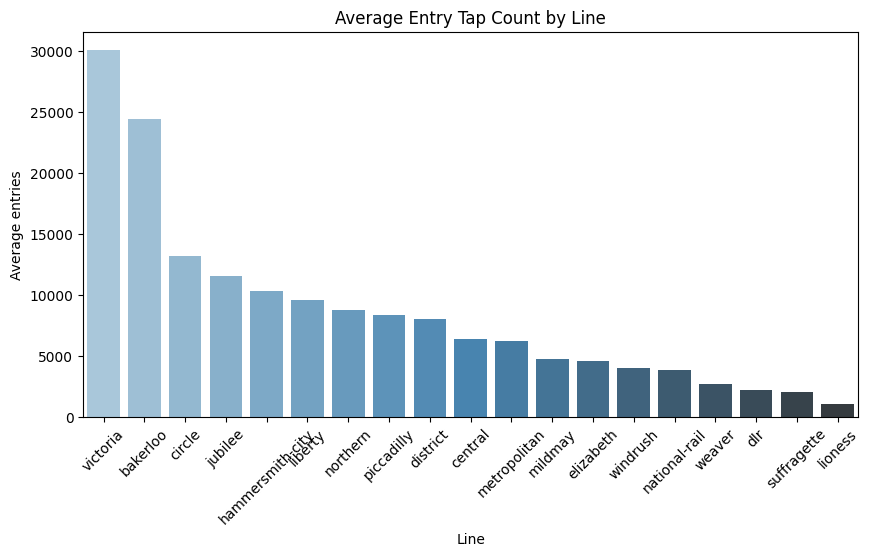

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# aggregate entrytapcount by line
line_demand = (df.groupby('line', as_index=False)['entrytapcount']
                 .mean()
                 .sort_values('entrytapcount', ascending=False))

# barplot
plt.figure(figsize=(10,5))
sns.barplot(data=line_demand, x='line', y='entrytapcount', palette="Blues_d")
plt.title("Average Entry Tap Count by Line")
plt.xticks(rotation=45)
plt.ylabel("Average entries")
plt.xlabel("Line")
plt.show()


In [134]:
df_tube.head()

,date,dayofweek,station_name,station_uid,mode,line,farezones,hubnaptancode,entrytapcount,exittapcount,...,service_operated_weekday_pct,service_operated_weekend_pct,kilometres_operated,wifi,airportinterchange,bluebadgecarparking,bluebadgecarparkspaces,toilet_isaccessible,toilet_isfeecharged,toilet_type
2,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Male
3,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Female
4,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,...,93.0,80.8,165295.0,True,NaN,False,0.0,True,False,Unisex
5,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,piccadilly,3,NaN,2608,3059,...,84.9,83.3,196661.0,True,NaN,False,0.0,False,False,Male
6,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,piccadilly,3,NaN,2608,3059,...,84.9,83.3,196661.0,True,NaN,False,0.0,False,False,Female


In [146]:
import pandas as pd

# show all columns when printing
pd.set_option('display.max_columns', None)


In [148]:
df_tube[df_tube['event_name'].isnull()] ### drop

,date,dayofweek,station_name,station_uid,mode,line,farezones,hubnaptancode,entrytapcount,exittapcount,event_type,event_name,expected_attendance,max_temp,min_temp,mean_temp,precipitation_amount,relative_humidity,cloud_cover,sunshine_duration,sea_level_pressure,service_operated_allweek_pct,service_operated_weekday_pct,service_operated_weekend_pct,kilometres_operated,wifi,airportinterchange,bluebadgecarparking,bluebadgecarparkspaces,toilet_isaccessible,toilet_isfeecharged,toilet_type
2,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,NaN,NaN,NaN,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,90.2,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Male
3,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,NaN,NaN,NaN,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,90.2,93.0,80.8,165295.0,True,NaN,False,0.0,False,False,Female
4,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,district,3,NaN,2608,3059,NaN,NaN,NaN,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,90.2,93.0,80.8,165295.0,True,NaN,False,0.0,True,False,Unisex
5,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,piccadilly,3,NaN,2608,3059,NaN,NaN,NaN,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,84.5,84.9,83.3,196661.0,True,NaN,False,0.0,False,False,Male
6,2023-01-01,Sunday,Acton Town,940GZZLUACT,tube,piccadilly,3,NaN,2608,3059,NaN,NaN,NaN,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,84.5,84.9,83.3,196661.0,True,NaN,False,0.0,False,False,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261021,2023-12-31,Sunday,Wood Lane,940GZZLUWLA,tube,hammersmith-city,2,NaN,4506,4981,NaN,NaN,NaN,12.4,5.7,8.2,1.6,85.0,7.0,0.5,989.1,91.6,92.7,88.8,NaN,True,NaN,False,0.0,True,False,Unisex
261023,2023-12-31,Sunday,Woodford,940GZZLUWOF,tube,central,4,NaN,4394,4164,NaN,NaN,NaN,12.4,5.7,8.2,1.6,85.0,7.0,0.5,989.1,82.6,84.1,78.4,211048.0,True,NaN,True,10.0,False,False,Male
261024,2023-12-31,Sunday,Woodford,940GZZLUWOF,tube,central,4,NaN,4394,4164,NaN,NaN,NaN,12.4,5.7,8.2,1.6,85.0,7.0,0.5,989.1,82.6,84.1,78.4,211048.0,True,NaN,True,10.0,False,False,Female
261026,2023-12-31,Sunday,Woodside Park,940GZZLUWOP,tube,northern,4,NaN,2546,1998,NaN,NaN,NaN,12.4,5.7,8.2,1.6,85.0,7.0,0.5,989.1,93.9,95.0,90.9,292774.0,True,NaN,True,5.0,False,False,Male


In [ ]:
service_operated_allweek_pct     16865
service_operated_weekday_pct     16865
service_operated_weekend_pct     16865
kilometres_operated              16865 input with median or mean


toilet_isaccessible	toilet_isfeecharged	toilet_type INPUT WOTH UNKNOWN

drop event event_name
and input event type with 'no event'